<a href="https://colab.research.google.com/github/YoshifumiMiyagi/KD_ML/blob/main/IP2_many_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
SEED=42
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import codecs

In [41]:
with codecs.open("/content/drive/MyDrive/R5_9_16DB1_Shizuoka_Unsupervised_1st.csv", "r", "Shift-JIS", "ignore") as file:
    df = pd.read_table(file, delimiter=",")

In [42]:
df = df.loc[:,['Age', 'Length', 'Weight', 'sex', '5th Criteria count_1', 'Season', 'Treat day',
       'IVIG-non-responder_1', 'IVIG_first',
       'preWBC_1',  'preNetro',  'pre_Lym', 'preCRP_1', 'prePlt','preTbil','preAST', 'preALT', 'preNa@', 'preIgG']]
df.columns = ['Age', 'Length', 'Weight', 'Sex', 'Criteria', 'Season','Treat day',
       'IVIG-nonres', '1st_line',
       'WBC',  'Neutrophil',  'lymphocyte', 'CRP','Plt','Tbil','AST', 'ALT', 'Na', 'IgG']
df['Sex'] = df['Sex'].replace('male',0).replace('female',1)
df['Season'] = df['Season'].replace('Spring',0).replace('Summer',1).replace('Autum',2).replace('Winter',3)
df_IVIG_res = df[(df['IVIG-nonres'] == 0)&(df['1st_line']=='IVIG')]
df_IVIG_res['Group'] = 1
df_IVIG_nonres = df[(df['IVIG-nonres'] == 1)&(df['1st_line']=='IVIG')]
df_IVIG_nonres['Group'] = 3
df_IVIG_PSL_res = df[(df['IVIG-nonres'] == 0)&(df['1st_line']=='IVIG_PSL')]
df_IVIG_PSL_res['Group'] = 2
df_IVIG_PSL_nonres = df[(df['IVIG-nonres'] == 1)&(df['1st_line']=='IVIG_PSL')]
df_IVIG_PSL_nonres['Group'] = 4
print(df_IVIG_res.shape, df_IVIG_nonres.shape, df_IVIG_PSL_res.shape, df_IVIG_PSL_nonres.shape)

Res = pd.concat([df_IVIG_res,df_IVIG_PSL_res])
Non = pd.concat([df_IVIG_nonres,df_IVIG_PSL_nonres])
Dat = pd.concat([Res,Non])
# Dat['NLR'] = Dat['Neutrophil']/Dat['lymphocyte']
# Dat['PLR'] = Dat['Plt']/Dat['lymphocyte']
X = Dat.drop('IVIG-nonres',axis=1).drop('1st_line',axis=1).drop('Group',axis=1)
y = Dat['Group']
print(X.shape, y.shape)

(908, 20) (213, 20) (89, 20) (10, 20)
(1220, 17) (1220,)


<ipython-input-42-fb8d4934d05c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IVIG_res['Group'] = 1
<ipython-input-42-fb8d4934d05c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IVIG_nonres['Group'] = 3
<ipython-input-42-fb8d4934d05c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

# Imputation

In [43]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

imp_mean = IterativeImputer(random_state=SEED)

Dx_2 = X.copy()

A= imp_mean.fit_transform(Dx_2)
A= pd.DataFrame(A)
A.index = Dx_2.index
A.columns = Dx_2.columns

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

SSE = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, random_state=SEED)
  kmeans.fit(A)
  SSE.append(kmeans.inertia_)


plt.plot(range(1, 11), SSE)

plt.xlabel('n_clusters')
plt.ylabel('sse')
plt.xticks(range(1,11,1))

plt.show()

# GMM

In [44]:
from matplotlib.colors import LogNorm
from sklearn import mixture

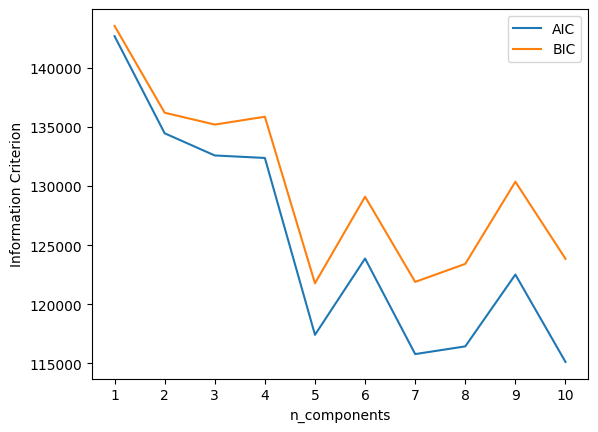

In [96]:
from sklearn import mixture
import matplotlib.pyplot as plt

AIC = []
BIC = []
for i in range(1, 11):
  kmeans = mixture.GaussianMixture(n_components=i, covariance_type='full')
  kmeans.fit(A)
  AIC.append(kmeans.aic(A))
  BIC.append(kmeans.bic(A))

plt.plot(range(1, 11), AIC, label='AIC')
plt.plot(range(1, 11), BIC, label='BIC')

plt.xlabel('n_components')
plt.ylabel('Information Criterion')
plt.xticks(range(1,11,1))
plt.legend()

plt.show()

In [124]:
clf = mixture.GaussianMixture(n_components=4, covariance_type='full')
clf.fit(A)

GaussianMixture(n_components=4)

In [125]:
labels = clf.predict(A)

In [126]:
labels

array([3, 3, 1, ..., 3, 0, 0])

In [127]:
k=4
for i in range(k):
    num = list(labels).count(i)
    print(f'Cluster {i}: n = {num}')

Cluster 0: n = 500
Cluster 1: n = 251
Cluster 2: n = 32
Cluster 3: n = 811


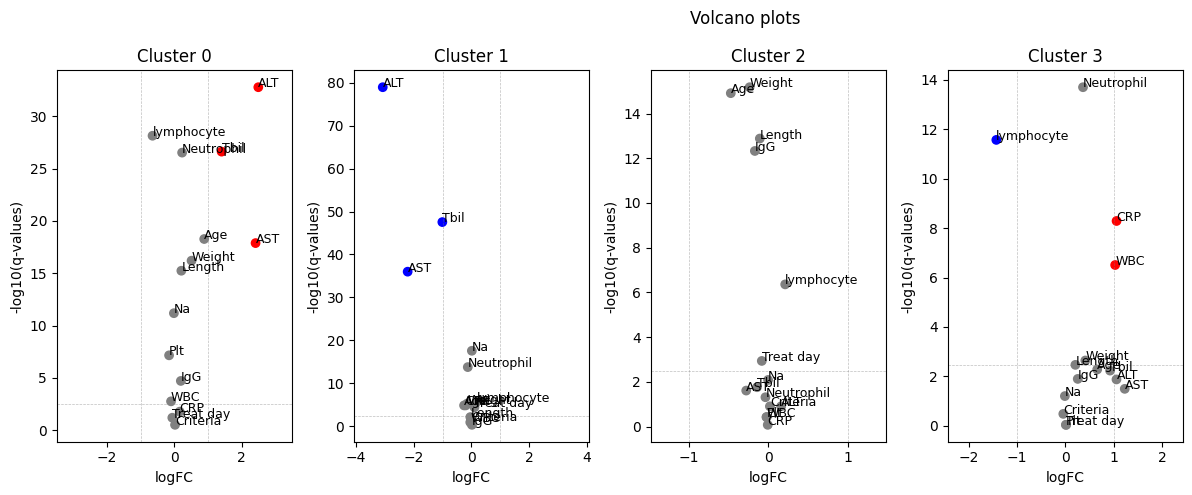

In [147]:
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

df_features_with_clusters = A.copy()
df_features_with_clusters['cluster'] = labels
cols = A.columns

q_threshold = 0.05/len(A.columns)
fc_threshold = 2

fig = plt.figure(figsize=(15,5))

for i in range(k):
    p_values = []
    fcs = []

    for col in cols:

        group_1 = df_features_with_clusters[df_features_with_clusters['cluster'] == i][col]
        group_2 = df_features_with_clusters[df_features_with_clusters['cluster'] != i][col]
        p_value = stats.ttest_ind(group_1, group_2, equal_var=False)[1]
        p_values.append(p_value)


        fc = group_1.mean()/group_2.mean()
        fcs.append(fc)


    q_values = multipletests(p_values, method='fdr_bh')[1]


    colors = []
    for col, q_value, fc in zip(cols, q_values, fcs):

        if q_value < q_threshold and fc > fc_threshold:
            colors.append('red')

        elif q_value < q_threshold and fc < 1/fc_threshold:
            colors.append('blue')

        else:
            colors.append('gray')

    ax = fig.add_subplot(1,5,i+1)
    ax.scatter(np.log2(fcs), -np.log10(q_values),
    c=colors)

    max_val = max(abs(np.nanmin(np.log2(fcs)[np.log2(fcs) != -np.inf])), max(np.log2(fcs)))
    ax.set_xlim([-max_val-1, max_val+1])
    ax.set_ylim(ax.get_ylim())


    ax.hlines([-np.log10(q_threshold)], -max_val-1, max_val+1, 'gray', 'dashed', linewidth=0.5, alpha=0.5)
    ax.vlines([np.log2(fc_threshold), np.log2(1/fc_threshold)], ax.get_ylim()[0], ax.get_ylim()[1], 'gray', 'dashed', linewidth=0.5, alpha=0.5)


    ax.set_title(f'Cluster {i}')
    ax.set_xlabel('logFC')
    ax.set_ylabel('-log10(q-values)')
    for j, label in enumerate(cols):
        ax.annotate(label, (np.log2(fcs)[j], -np.log10(q_values)[j]), size=9)

fig.suptitle('Volcano plots')
fig.tight_layout()
plt.show()

In [148]:
B = df_features_with_clusters.copy()
B['Group'] = y

In [149]:
#B[B['cluster']==0]["Group"].value_counts(),B[B['cluster']==1]["Group"].value_counts()
print(B[B['cluster']==0]["Group"].value_counts(),
      B[B['cluster']==1]["Group"].value_counts(),
      B[B['cluster']==2]["Group"].value_counts(),
      B[B['cluster']==3]["Group"].value_counts())
#      ,B[B['cluster']==4]["Group"].value_counts())

Group
1.0    131
3.0     54
2.0     34
4.0      3
Name: count, dtype: int64 Group
1.0    612
3.0     99
2.0     28
4.0      3
Name: count, dtype: int64 Group
1.0    335
3.0     78
2.0     35
4.0      4
Name: count, dtype: int64 Group
1.0    12
2.0     8
3.0     6
Name: count, dtype: int64


In [150]:
import scipy.stats as st
df = pd.DataFrame([[B[B['cluster']==0]["Group"].value_counts().values[0],
                    B[B['cluster']==1]["Group"].value_counts().values[0],
                    B[B['cluster']==2]["Group"].value_counts().values[0],
                    B[B['cluster']==3]["Group"].value_counts().values[0]],
#                    B[B['cluster']==4]["Group"].value_counts().values[0]],
                   [B[B['cluster']==0]["Group"].value_counts().values[1],
                    B[B['cluster']==1]["Group"].value_counts().values[1],
                    B[B['cluster']==2]["Group"].value_counts().values[1],
                    B[B['cluster']==3]["Group"].value_counts().values[1]]])
#,
#                    B[B['cluster']==4]["Group"].value_counts().values[1]]])
x2, p1, dof, e = st.chi2_contingency(df,correction=False)

print(p1)

1.08600913718568e-06


In [151]:
df

,0,1,2,3
0,131,612,335,12
1,54,99,78,8


In [138]:
df = pd.DataFrame([[B[B['cluster']==0]["Group"].value_counts().values[2],
                    B[B['cluster']==1]["Group"].value_counts().values[2],
                    B[B['cluster']==2]["Group"].value_counts().values[2],
                    B[B['cluster']==3]["Group"].value_counts().values[2]],
#                    B[B['cluster']==4]["Group"].value_counts().values[2]],
                   [B[B['cluster']==0]["Group"].value_counts().values[3],
                    B[B['cluster']==1]["Group"].value_counts().values[3],
#                    B[B['cluster']==2]["Group"].value_counts().values[3],
                    0,
                    B[B['cluster']==3]["Group"].value_counts().values[3]]])
#,
#                    B[B['cluster']==4]["Group"].value_counts().values[3]]])
x2, p1, dof, e = st.chi2_contingency(df,correction=False)

print(p1)

0.8661797088407839


In [139]:
df

,0,1,2,3
0,35,34,6,28
1,4,3,0,3


# Shizuoka+Chutou

In [140]:
raw2 = pd.read_csv("/content/drive/MyDrive/iwashima_project_2.csv", encoding='cp932')
add = pd.read_csv("/content/drive/MyDrive/Dr.Miyagi_R6_5_31_DB_1_add.csv", encoding='cp932')
raw3 = pd.merge(raw2.T, add.T, left_index=True, right_index=True).T

raw3_2 = raw3.loc[:,['Age', 'Length', 'Weight', 'sex', '5th Criteria count',
       'Treat day', 'preWBC_1',  'preNetro',  'pre_Lym', 'preCRP_1',
       'prePlt','preTbil','preAST', 'preALT', 'preNa', 'preIgG']]
raw3_2.columns = ['Age', 'Length', 'Weight', 'sex', 'Criteria',
       'Treat day', 'WBC',  'Neutrophil',  'lymphocyte', 'CRP',
       'Plt','Tbil','AST', 'ALT', 'Na', 'IgG']
raw3_2['sex'] = raw3_2['sex'].replace('F',0).replace('M',1).replace('female',0).replace('male',1)
Dx_2 = raw3_2
Dy_2 = raw3.loc[:,"Response"]
Dat2 = Dx_2.copy()
# Dat2['NLR'] = Dat2['Neutrophil']/Dat2['lymphocyte']
# Dat2['PLR'] = Dat2['Plt']/Dat2['lymphocyte']
DF = pd.concat([X,Dat2],join='inner')
DF.shape  ,DF.columns

((1594, 15),
 Index(['Age', 'Length', 'Weight', 'Criteria', 'Treat day', 'WBC', 'Neutrophil',
        'lymphocyte', 'CRP', 'Plt', 'Tbil', 'AST', 'ALT', 'Na', 'IgG'],
       dtype='object'))

In [141]:
DF_y = pd.concat([y,Dy_2])
DF_y.columns = ['Group']
DF_y.value_counts()

1    1134
3     243
2     194
4      23
Name: count, dtype: int64

In [142]:
imp_mean = IterativeImputer(random_state=SEED)
A= imp_mean.fit_transform(DF)
A= pd.DataFrame(A)
A.index = DF.index
A.columns = DF.columns

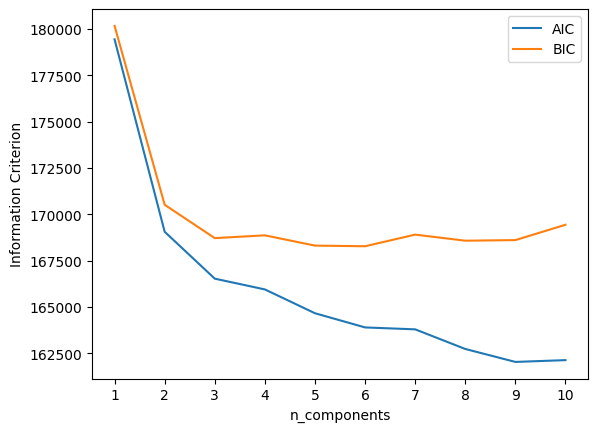

In [153]:
from sklearn import mixture
import matplotlib.pyplot as plt

AIC = []
BIC = []
for i in range(1, 11):
  kmeans = mixture.GaussianMixture(n_components=i, covariance_type='full')
  kmeans.fit(A)
  AIC.append(kmeans.aic(A))
  BIC.append(kmeans.bic(A))

plt.plot(range(1, 11), AIC, label='AIC')
plt.plot(range(1, 11), BIC, label='BIC')

plt.xlabel('n_components')
plt.ylabel('Information Criterion')
plt.xticks(range(1,11,1))
plt.legend()

plt.show()

In [161]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

#Z = linkage(X, metric='mahalanobis')
Z = linkage(A, method ='ward',metric='euclidean')
silhouette_coefficient = []
calinski_harabasz_index = []
davies_bouldin_index = []

NUM_CLUSTERS_RANGE = range(2,15)
for num in NUM_CLUSTERS_RANGE:
    labels = fcluster(Z, t=num, criterion='maxclust')

    silhouette_coefficient.append(silhouette_score(A, labels))
    calinski_harabasz_index.append(calinski_harabasz_score(A, labels))
    davies_bouldin_index.append(davies_bouldin_score(A, labels))

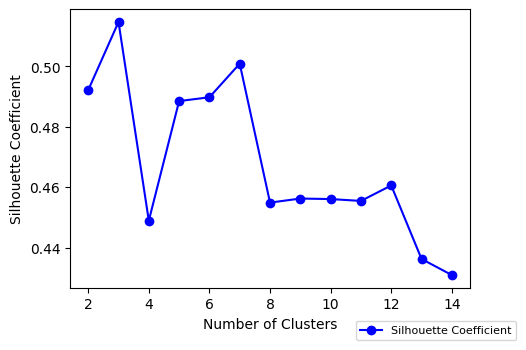

In [163]:
fig = plt.figure()
fig.subplots_adjust(bottom=0.3,right=0.75)
host = fig.add_subplot(111)

#par1 = host.twinx()
#par2 = host.twinx()

p0, = host.plot(NUM_CLUSTERS_RANGE, silhouette_coefficient, 'bo-', label='Silhouette Coefficient')
#p1, = par1.plot(NUM_CLUSTERS_RANGE, calinski_harabasz_index, 'rd-', label='Calinski Harabasz Index')
#p2, = par2.plot(NUM_CLUSTERS_RANGE, davies_bouldin_index, 'gs-', label='Davies Bouldin Index')

host.set_xlabel('Number of Clusters')
host.set_ylabel('Silhouette Coefficient')
#par1.set_ylabel('Calinski Harabasz Index')
#par2.set_ylabel('Davies Bouldin Index')

#par2.spines['right'].set_position(('axes', 1.15))

lines = [p0,
         #p1,
         #p2
         ]
host.legend(lines,
            [l.get_label() for l in lines],
            fontsize=8,
            bbox_to_anchor=(0.7, -0.1),
            loc='upper left')

fig.show()

In [166]:
clf = mixture.GaussianMixture(n_components=4, covariance_type='full')
clf.fit(A)

labels = clf.predict(A)

k=4
for i in range(k):
    num = list(labels).count(i)
    print(f'Cluster {i}: n = {num}')

Cluster 0: n = 813
Cluster 1: n = 251
Cluster 2: n = 26
Cluster 3: n = 504


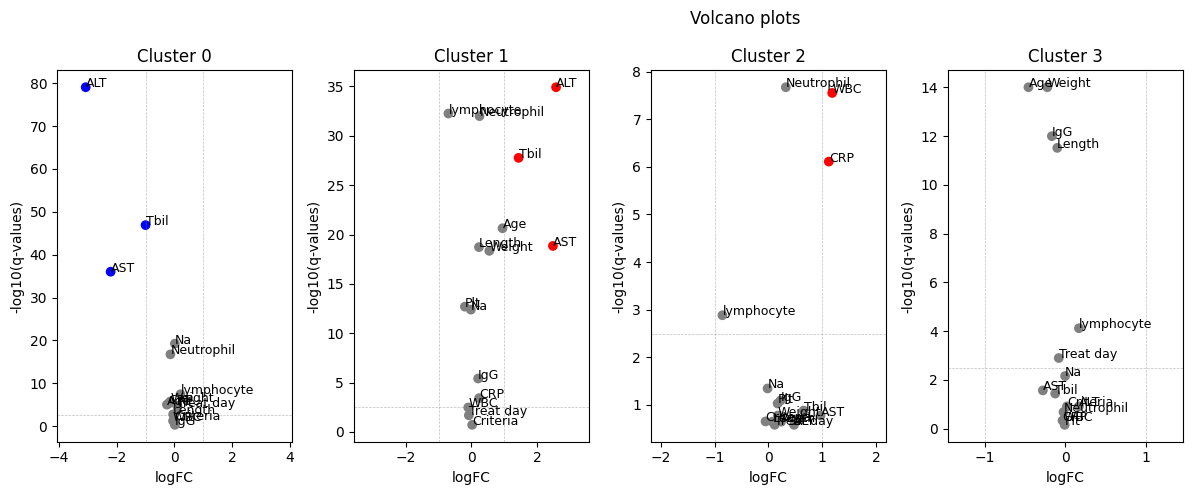

In [167]:
df_features_with_clusters = A.copy()
df_features_with_clusters['cluster'] = labels
cols = A.columns

q_threshold = 0.05/len(A.columns)
fc_threshold = 2

fig = plt.figure(figsize=(15,5))

for i in range(k):
    p_values = []
    fcs = []

    for col in cols:

        group_1 = df_features_with_clusters[df_features_with_clusters['cluster'] == i][col]
        group_2 = df_features_with_clusters[df_features_with_clusters['cluster'] != i][col]
        p_value = stats.ttest_ind(group_1, group_2, equal_var=False)[1]
        p_values.append(p_value)


        fc = group_1.mean()/group_2.mean()
        fcs.append(fc)


    q_values = multipletests(p_values, method='fdr_bh')[1]


    colors = []
    for col, q_value, fc in zip(cols, q_values, fcs):

        if q_value < q_threshold and fc > fc_threshold:
            colors.append('red')

        elif q_value < q_threshold and fc < 1/fc_threshold:
            colors.append('blue')

        else:
            colors.append('gray')

    ax = fig.add_subplot(1,5,i+1)
    ax.scatter(np.log2(fcs), -np.log10(q_values),
    c=colors)

    max_val = max(abs(np.nanmin(np.log2(fcs)[np.log2(fcs) != -np.inf])), max(np.log2(fcs)))
    ax.set_xlim([-max_val-1, max_val+1])
    ax.set_ylim(ax.get_ylim())


    ax.hlines([-np.log10(q_threshold)], -max_val-1, max_val+1, 'gray', 'dashed', linewidth=0.5, alpha=0.5)
    ax.vlines([np.log2(fc_threshold), np.log2(1/fc_threshold)], ax.get_ylim()[0], ax.get_ylim()[1], 'gray', 'dashed', linewidth=0.5, alpha=0.5)


    ax.set_title(f'Cluster {i}')
    ax.set_xlabel('logFC')
    ax.set_ylabel('-log10(q-values)')
    for j, label in enumerate(cols):
        ax.annotate(label, (np.log2(fcs)[j], -np.log10(q_values)[j]), size=9)

fig.suptitle('Volcano plots')
fig.tight_layout()
plt.show()

In [209]:
B = df_features_with_clusters.copy()
B['Group'] = y

In [210]:
#B[B['cluster']==0]["Group"].value_counts(),B[B['cluster']==1]["Group"].value_counts()
print(B[B['cluster']==0]["Group"].value_counts(),
      B[B['cluster']==1]["Group"].value_counts(),
      B[B['cluster']==2]["Group"].value_counts(),
      B[B['cluster']==3]["Group"].value_counts())
#      ,B[B['cluster']==4]["Group"].value_counts())

Group
1.0    614
3.0     97
2.0     29
4.0      3
Name: count, dtype: int64 Group
1.0    127
3.0     55
2.0     35
4.0      3
Name: count, dtype: int64 Group
1.0    10
3.0     7
2.0     6
Name: count, dtype: int64 Group
1.0    339
3.0     78
2.0     35
4.0      4
Name: count, dtype: int64


In [211]:
B[B['cluster']==3]["Group"].value_counts()

Group
1.0    339
3.0     78
2.0     35
4.0      4
Name: count, dtype: int64

In [212]:
import scipy.stats as st
df = pd.DataFrame([[B[B['cluster']==0]["Group"].value_counts().values[0],
                    B[B['cluster']==1]["Group"].value_counts().values[0],
                    B[B['cluster']==2]["Group"].value_counts().values[0],
                    B[B['cluster']==3]["Group"].value_counts().values[0]],
#                    B[B['cluster']==4]["Group"].value_counts().values[0]],
                   [B[B['cluster']==0]["Group"].value_counts().values[1],
                    B[B['cluster']==1]["Group"].value_counts().values[1],
                    B[B['cluster']==2]["Group"].value_counts().values[1]
,
                    B[B['cluster']==3]["Group"].value_counts().values[1]]])
#,
#                    B[B['cluster']==4]["Group"].value_counts().values[1]]])
x2, p1, dof, e = st.chi2_contingency(df,correction=False)

print(p1)

1.9103134625141073e-07


In [213]:
df

,0,1,2,3
0,614,127,10,339
1,97,55,7,78


In [215]:
df = pd.DataFrame([[B[B['cluster']==0]["Group"].value_counts().values[2],
                    B[B['cluster']==1]["Group"].value_counts().values[2],
                    B[B['cluster']==2]["Group"].value_counts().values[2],
                    B[B['cluster']==3]["Group"].value_counts().values[2]],
#                    B[B['cluster']==4]["Group"].value_counts().values[2]],
                   [B[B['cluster']==0]["Group"].value_counts().values[3],
                    B[B['cluster']==1]["Group"].value_counts().values[3],
#                    B[B['cluster']==2]["Group"].value_counts().values[3]
0,
                    B[B['cluster']==3]["Group"].value_counts().values[3]]])
#,
#                    B[B['cluster']==4]["Group"].value_counts().values[3]]])
x2, p1, dof, e = st.chi2_contingency(df,correction=False)

print(p1)

0.8636652458702636


In [216]:
df

,0,1,2,3
0,29,35,6,35
1,3,3,0,4


In [233]:
df = pd.DataFrame([[127,10],[55,7]])
x2, p1, dof, e = st.chi2_contingency(df,correction=True)

print(p1)

0.5098661868304594


In [225]:
df

,0
55,127
78,339


# DBSCAN

In [204]:
from sklearn.cluster import DBSCAN
import numpy as np

# DBSCANの実装
db = DBSCAN(eps=100, min_samples=5).fit(A)

# クラスタリングの結果
labels = db.labels_

print("クラスタラベル:", labels)


クラスタラベル: [-1 -1 -1 ... -1 -1 -1]


In [205]:
pd.DataFrame(labels).value_counts()

-1     1047
 2       49
 6       31
 9       30
 17      29
 18      28
 16      21
 19      21
 5       19
 7       18
 20      16
 12      16
 31      15
 13      14
 34      13
 23      13
 35      12
 22      12
 15      12
 3       12
 25      11
 24       9
 30       9
 42       8
 27       8
 8        8
 21       7
 11       7
 0        6
 43       6
 28       6
 14       6
 33       6
 37       5
 44       5
 41       5
 40       5
 39       5
 4        5
 36       5
 1        5
 32       5
 29       5
 26       5
 10       5
 45       5
 38       4
Name: count, dtype: int64